In [18]:
import numpy as np
from datasets import load_dataset
import transformers
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
)
from sklearn.metrics import accuracy_score, f1_score

print(transformers.__version__)


4.56.1


In [4]:
!wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt
!wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt

--2025-09-16 23:52:10--  https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4893335 (4.7M) [application/octet-stream]
Saving to: ‘ratings_test.txt’

ratings_test.txt    100%[===================>]   4.67M  --.-KB/s    in 0.05s   

2025-09-16 23:52:10 (97.4 MB/s) - ‘ratings_test.txt’ saved [4893335/4893335]

--2025-09-16 23:52:10--  https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14628807 (14M) [text/pl

In [5]:
import pandas as pd
from datasets import Dataset, DatasetDict

# 로컬에서 불러오기
train_df = pd.read_csv("ratings_train.txt", sep="\t")
test_df = pd.read_csv("ratings_test.txt", sep="\t")

# Dataset으로 변환
train_ds = Dataset.from_pandas(train_df)
test_ds = Dataset.from_pandas(test_df)

# train/val 나누기
train_valid = train_ds.train_test_split(test_size=0.1, seed=42)
train_ds = train_valid["train"]
val_ds = train_valid["test"]

dataset = DatasetDict({
    "train": train_ds,
    "validation": val_ds,
    "test": test_ds
})

print(dataset)


DatasetDict({
    train: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 135000
    })
    validation: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 15000
    })
    test: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 50000
    })
})


In [ ]:
#결측치 제거
train_ds = train_ds.filter(lambda x: x["document"] is not None)
val_ds = val_ds.filter(lambda x: x["document"] is not None)
test_ds = test_ds.filter(lambda x: x["document"] is not None)


In [ ]:
# 2. 모델과 토크나이저 준비
MODEL_NAME = "klue/bert-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")

def preprocess(batch):
    return tokenizer(
        batch["document"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

train_ds = train_ds.map(preprocess, batched=True)
val_ds = val_ds.map(preprocess, batched=True)
test_ds = test_ds.map(preprocess, batched=True)



In [15]:
# 4. metric 정의
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [20]:
# 5. 학습 파라미터
training_arguments = TrainingArguments(
    output_dir="klue_nsmc_output",
    eval_strategy="epoch",   # epoch마다 평가
    save_strategy="epoch",         # epoch마다 저장
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",              # wandb 같은 로그 끔
)

In [21]:
# 6. Trainer 정의
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_arguments,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

/tmp/ipython-input-1559849195.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [22]:
# 7. 학습
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.254100,0.253286,0.905467,0.904525
2,0.183900,0.266623,0.910333,0.910933
3,0.125100,0.371903,0.910133,0.910894


TrainOutput(global_step=25314, training_loss=0.19935039834613774, metrics={'train_runtime': 9337.7695, 'train_samples_per_second': 43.371, 'train_steps_per_second': 2.711, 'total_flos': 2.66390076887424e+16, 'train_loss': 0.19935039834613774, 'epoch': 3.0})

버케팅 실시하면 2시간 소요됨

In [23]:
# 8. 평가 (Validation + Test)
print("Validation 결과:", trainer.evaluate(eval_dataset=val_ds))
print("Test 결과:", trainer.evaluate(eval_dataset=test_ds))

Validation 결과: {'eval_loss': 0.26662346720695496, 'eval_accuracy': 0.9103333333333333, 'eval_f1': 0.9109330507913384, 'eval_runtime': 106.5484, 'eval_samples_per_second': 140.781, 'eval_steps_per_second': 4.402, 'epoch': 3.0}
Test 결과: {'eval_loss': 0.27579471468925476, 'eval_accuracy': 0.9042742564553873, 'eval_f1': 0.905653682384482, 'eval_runtime': 351.258, 'eval_samples_per_second': 142.337, 'eval_steps_per_second': 4.45, 'epoch': 3.0}


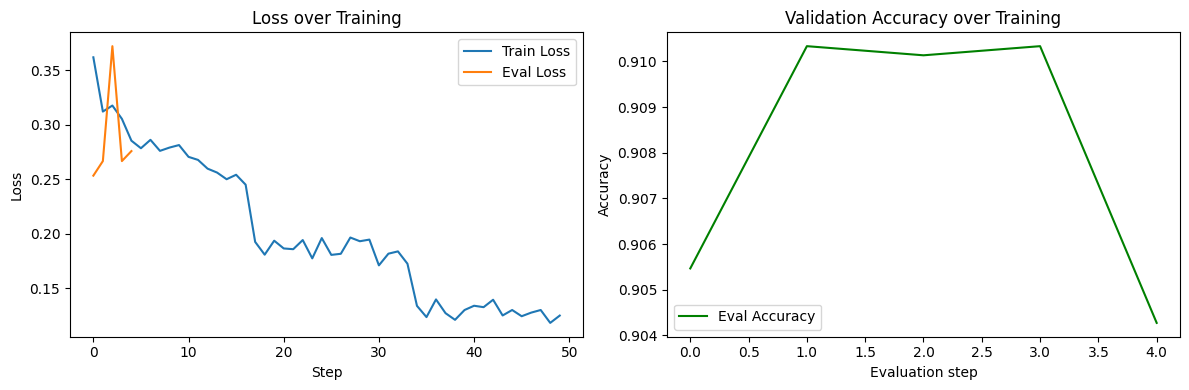

In [24]:
import matplotlib.pyplot as plt

# Trainer가 기록한 로그(history)를 가져옵니다.
logs = trainer.state.log_history

# loss, eval_loss, eval_accuracy 등 분리
train_loss = [x['loss'] for x in logs if 'loss' in x]
eval_loss = [x['eval_loss'] for x in logs if 'eval_loss' in x]
eval_accuracy = [x['eval_accuracy'] for x in logs if 'eval_accuracy' in x]

# 학습 손실 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(eval_loss, label='Eval Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Loss over Training')
plt.legend()

# 평가 정확도 시각화
plt.subplot(1, 2, 2)
plt.plot(eval_accuracy, label='Eval Accuracy', color='green')
plt.xlabel('Evaluation step')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Training')
plt.legend()

plt.tight_layout()
plt.show()


https://medium.com/data-science/divide-hugging-face-transformers-training-time-by-2-or-more-21bf7129db9q-21bf7129db9e  
를 읽어보면 Dynamic Padding과 Bucketing을 적용하면 훈련 시간이 단축되고, 모델 성능이 향상되었다. 배치 크기 64에서 훈련 시간이 48분에서 30분으로 단축되었으며, 정확도는 81.0%에서 81.7%로 향상되었다

NSMC와 KLUE/BERT fine-tuning 과정에서 데이터 전처리와 토큰화 과정의 안정성이 매우 중요하다고 느낌

Dynamic Padding과 Bucketing을 적용하면 싷험적으론 학습 속도와 모델 성능 모두 개선 가능

앞으로 실제 프로젝트에서 대용량 데이터 학습 시 메모리 최적화와 배치 구성 전략을 반드시 고려해야 한다고 생각함